In [81]:
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import json
import operator
from langdetect import detect, detect_langs
from joblib import Parallel, delayed
import numpy as np

In [82]:
province = 'izmir'
preprocessing_dir = '/home/emotionlex/Documents/newest/instaturkeydata/PREPROCESSING/'
en_ids = open(preprocessing_dir+province+"_en_ids.txt", "a")
tr_ids = open(preprocessing_dir+province+"_tr_ids.txt", "a")
# ca_ids = open("../../../ssd2/instaBarcelona/ca_ids.txt", "w")
out_file = open('/home/emotionlex/Documents/newest/instaturkeydata/'+province+"_lang_data.json", 'w')
out_file_all = open('/home/emotionlex/Documents/newest/instaturkeydata/'+province+" _lang_data_all.json", 'w')

In [83]:
# omited_words_file = open("../../../ssd2/instaBarcelona/words_2_filter.txt", "r")
# omited_words = []
# for line in omited_words_file:
#     w = unicode(line.rstrip(), "utf-8")
#     omited_words.append(w)
  

print ("Loading data")
with open("/home/emotionlex/Documents/newest/instaturkeydata/JSONS/"+province+'_extracted_captions.json', "r") as file:
    data = json.load(file)

print ("Counting languages")
languages = {'en': 0, 'tr': 0}
all_languages = {}
en = []
tr = []
# ca = []

Loading data
Counting languages


In [84]:
def detect_lang(k, v):
    cap_lan = "unknown"
    caption = v.replace('#', ' ')
    caption = caption.replace('\n', ' ')
    caption = caption.rstrip()
    caption = caption.lower()

    # for word2omit in omited_words:
    #     if word2omit in caption:
    #         print caption
    #         caption = caption.replace(word2omit, ' ')
    #         print caption

    it = 0
    while cap_lan == "unknown":  # Using while because the LSTM gives different answers, and we are supposed to have fitlered other languages
        try:
            langs = detect_langs(caption)
            for cur_lan in langs:
                cur_lan_str = str(cur_lan).split(':')[0]
                # Assign to one of the used languages
                if cur_lan_str in languages.keys():
                    cap_lan = cur_lan_str
                    break
        except:
            print ("Lang detection failed. Continuing")

        it += 1
        if it == 10:
            # print "Limit of iterations reached. Continuing"
            break

    # if cap_lan is 'unknown':
    #    print "Lang not found"

    # Save language with higher prob
    try:
        cap_lan_higher_prob = str(langs[0]).split(':')[0]
    except:
        cap_lan_higher_prob = "unknown"

    return k + ',' + cap_lan + ',' + cap_lan_higher_prob

In [85]:
parallelizer = Parallel(n_jobs=12)
tasks_iterator = (delayed(detect_lang)(k, v) for k, v in data.items())
r = parallelizer(tasks_iterator)
# merging the output of the jobs
strings = np.vstack(r)
print ("Computing done, geting results...")

dicarded = 0
for r in strings:
    k = r[0].split(',')[0]
    cap_lan = r[0].split(',')[1]
    cap_lan_higher = r[0].split(',')[2]
    if cap_lan == 'unknown':
        print ("Unknown language")
        dicarded += 1
        continue
    if cap_lan == 'en':
        en.append(k)
    elif cap_lan == 'tr':
        tr.append(k)
    # elif cap_lan == 'ca':
    #     ca.append(k)
    languages[cap_lan] += 1

    if cap_lan_higher in all_languages:
        all_languages[cap_lan_higher] += 1
    else:
        all_languages[cap_lan_higher] = 1

Computing done, geting results...


In [86]:
print ("SELECTED LANGUAGES")
print (languages)
print ("Number of languages: " + str(len(languages.values())))
print ("Languages with max repetitions has:  " + str(max(languages.values())))
print ("Discarded intances:  " + str(dicarded))

print ("ALL")
print (all_languages)
print ("Number of languages: " + str(len(all_languages.values())))
print ("Languages with max repetitions has:  " + str(max(all_languages.values())))

SELECTED LANGUAGES
{'en': 1041, 'tr': 6041}
Number of languages: 2
Languages with max repetitions has:  6041
Discarded intances:  0
ALL
{'tr': 6005, 'en': 986, 'fr': 2, 'no': 29, 'sq': 1, 'nl': 4, 'it': 9, 'ca': 1, 'da': 4, 'sl': 5, 'hu': 1, 'lv': 6, 'hr': 4, 'id': 8, 'sv': 4, 'et': 1, 'cy': 2, 'ro': 4, 'de': 1, 'af': 2, 'so': 1, 'pl': 1, 'ru': 1}
Number of languages: 23
Languages with max repetitions has:  6005


In [87]:
json.dump(languages, out_file)
out_file.close()
json.dump(all_languages, out_file_all)
out_file_all.close()

In [88]:
print ("Saving id's per language")
for id in en: en_ids.write(str(id) + '\n')
for id in tr: tr_ids.write(str(id) + '\n')
# for id in ca: ca_ids.write(str(id) + '\n')
en_ids.close()
tr_ids.close()
# ca_ids.close()

Saving id's per language


<BarContainer object of 2 artists>

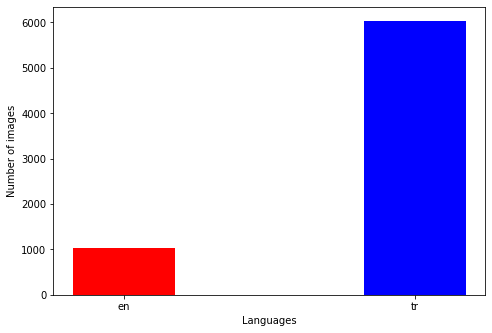

In [89]:
# Plot
lan_sorted = sorted(languages.items(), key=operator.itemgetter(1))
lan_count_sorted = languages.values()
# plt.legend(['English','Trukish'])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Number of images')
ax.set_xlabel('Languages')
ax.bar(languages.keys(),lan_count_sorted,color =['r','b'],width=0.35)
# ax.axes.legend(['English','Turkish'])


In [90]:
print(languages.keys())

dict_keys(['en', 'tr'])


In [91]:
# # Plot
# lan_sorted = sorted(languages.items(), key=operator.itemgetter(1))
# lan_count_sorted = languages.values()
# # lan_count_sorted.sort(reverse=True) #??????????????????????????????????????????????????????????????????????????????
# # sorted(lan_count_sorted,reverse=True)
# topX = min(10, len(lan_count_sorted))
# x = range(topX)
# my_xticks = []
# for l in range(0, topX):
#     my_xticks.append(lan_sorted[-l - 1][0])
# plt.xticks(x, my_xticks, size=11)
# width = 1 / 1.5
# plt.bar(x, lan_count_sorted[0], width, color="brown", align="center")
# plt.title("Number of images per language")
# plt.tight_layout()
# plt.show()

In [92]:
# # Plot %
# lan_sorted = sorted(languages.items(), key=operator.itemgetter(1))
# lan_count_sorted = languages.values()
# # lan_count_sorted.sort(reverse=True)
# # sorted(lan_count_sorted,reverse=True)
# topX = min(10, len(lan_count_sorted))
# x = range(topX)
# my_xticks = []
# total = sum(lan_count_sorted)
# for i, v in lan_count_sorted:
#     lan_count_sorted[i] = v / total * 100

# for l in range(0, topX):
#     my_xticks.append(lan_sorted[-l - 1][0])
# plt.xticks(x, my_xticks, size=11)
# width = 1 / 1.5
# plt.bar(x, lan_count_sorted[0:topX], width, color="brown", align="center")
# plt.title("% of images per language")
# plt.tight_layout()
# plt.show()

In [93]:
# # Plot
# lan_sorted = sorted(all_languages.items(), key=operator.itemgetter(1))
# lan_count_sorted = all_languages.values()
# # lan_count_sorted.sort(reverse=True)
# # sorted(lan_count_sorted,reverse=True)
# topX = min(20, len(lan_count_sorted))
# x = range(topX)
# my_xticks = []
# for l in range(0, topX):
#     my_xticks.append(lan_sorted[-l - 1][0])
# plt.xticks(x, my_xticks, size=11)
# width = 1 / 1.5
# plt.bar(x, lan_count_sorted[0:topX], width, color="brown", align="center")
# plt.title("Number of images per language")
# plt.tight_layout()
# plt.show()

In [94]:
# # Plot %
# lan_sorted = sorted(all_languages.items(), key=operator.itemgetter(1))
# lan_count_sorted = all_languages.values()
# # lan_count_sorted.sort(reverse=True)
# # sorted(lan_count_sorted,reverse=True)
# topX = min(20, len(all_languages))
# x = range(topX)
# my_xticks = []
# total = sum(lan_count_sorted)
# for i, v in lan_count_sorted:
#     lan_count_sorted[i] = v / total * 100

# for l in range(0, topX):
#     my_xticks.append(lan_sorted[-l - 1][0])
# plt.xticks(x, my_xticks, size=11)
# width = 1 / 1.5
# plt.bar(x, lan_count_sorted[0:topX], width, color="brown", align="center")
# plt.title("% of images per language")
# plt.tight_layout()
# plt.show()

# print ("Done")